**Import Libraries and Define constants**

In [1]:
#### Training based on features of audio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sknn.mlp import Classifier, Layer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots_adjust



WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.1

**Load data**

In [2]:
##Loading  data from files
filehandlerInput = open('processed-data/input_VAD.obj', 'rb')
filehandlerOutput = open('processed-data/output_VAD.obj', 'rb')
filehandlerTranscript = open('processed-data/transcript_VAD.obj', 'rb')
input = pickle.load(filehandlerInput)
output = pickle.load(filehandlerOutput)
texts = pickle.load(filehandlerTranscript)
print("Size input, output, transcripts: ", len(input),", ", len(output), ",", len(texts))


Size input, output, transcripts:  10018 ,  10018 , 10018


**Preprocess data and Analyze data**

Distinct output:  {0.5, 1.5, 2.5, 3.5, 3.0, 4.0, 2.0, 4.5, 5.0, 1.0, 2.3333, 2.6667, 4.3333, 2.25, 2.75, 3.25, 3.75, 4.75, 4.25, 5.5, 1.3333, 3.3333, 4.6667, 1.6667, 3.6667}
Average labels: 2.7782824016769814
Std labels: 0.8970523348000802


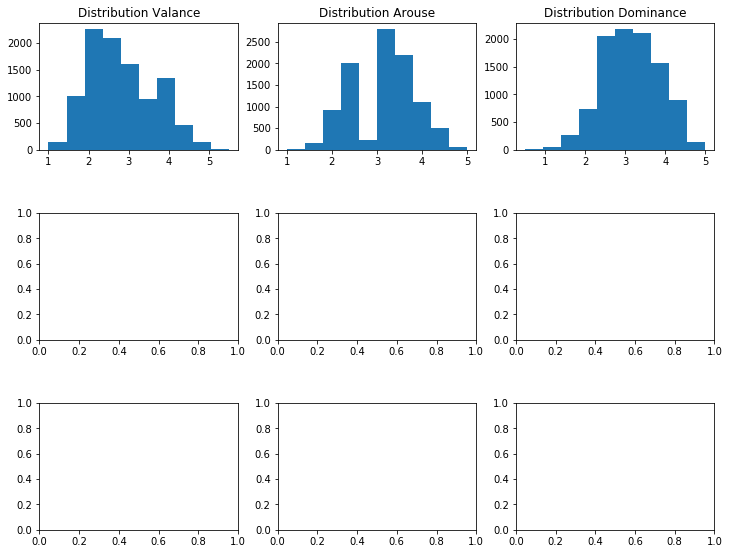

In [3]:
fig, axs = plt.subplots(3,3, figsize=(5,8))
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)


## Draw distribution of raw output
flattened_out = output.flatten()
print("Distinct output: ", set(flattened_out));
print("Average labels:", np.average(output[:,0]))
print("Std labels:", np.std(output[:,0]))
axs[0][0].hist(output[:,0])
axs[0][0].set_title("Distribution Valance")
axs[0][1].hist(output[:,1])
axs[0][1].set_title("Distribution Arouse")
axs[0][2].hist(output[:,2])
axs[0][2].set_title("Distribution Dominance")





## Around output into integer.
# for i in range(0, output.size):
#     output.flat[i] = int(np.round(output.flat[i]))
# output = output.astype(int)

# flattened_out = output.flatten()
# print("\nDistinct output: ", set(flattened_out));
# print("Average labels:", np.average(output[:,0]))
# print("Std labels:", np.std(output[:,0]))
# axs[1][0].hist(output[:,0])
# axs[1][0].set_title("Distribution Valance")
# axs[1][1].hist(output[:,1])
# axs[1][1].set_title("Distribution Arouse")
# axs[1][2].hist(output[:,2])
# axs[1][2].set_title("Distribution Dominance")
plt.show()


**Preprocess data**

Using TensorFlow backend.


Size input, output, texts after remove Nan values  10009 ,  10009 ,  10009
(10009, 3)


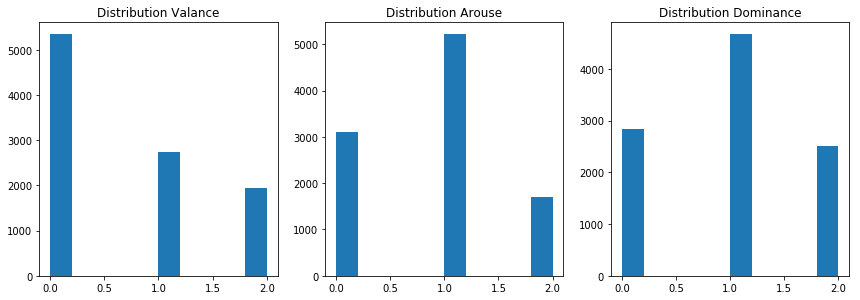

Normalize input and categorize output 
10009


In [4]:
from keras.utils.np_utils import to_categorical

input_filtered = input[~np.any(np.isnan(input), axis=1)]
input_filtered = input_filtered[:,0:88]
output_filtered = output[~np.any(np.isnan(input), axis=1)]
texts_filtered = texts[~np.any(np.isnan(input), axis=1)]
print("Size input, output, texts after remove Nan values ", len(input_filtered), ", ", len(output_filtered), ", ", len(texts_filtered))

#Normalize input
input_filtered = (input_filtered - input_filtered.min(axis=0)) / (input_filtered.max(axis=0) - input_filtered.min(axis=0))

#Normalize output
def categorize_output(output):
    if (output <= 2.5):
        return 0
    elif  output >= 4:
        return 2
    else:
        return 1

# def categorize_output(output):
#     return np.around(output)
   
print(output_filtered.shape)

output_filtered = np.array([list(map(lambda x: categorize_output(x), col)) for col in output_filtered])


fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
axs[0].hist(output_filtered[:,0])
axs[0].set_title("Distribution Valance")
axs[1].hist(output_filtered[:,1])
axs[1].set_title("Distribution Arouse")
axs[2].hist(output_filtered[:,2])
axs[2].set_title("Distribution Dominance")
plt.show()




#pprint(output_filtered)
output_filtered = [to_categorical(out, 3) for out in output_filtered]
#output_filtered = (output_filtered - output_filtered.min(axis=0)) / (output_filtered.max(axis=0) - output_filtered.min(axis=0))
print("Normalize input and categorize output ")
print(len(output_filtered))



**Shuffer data**

In [5]:
#Shuffer
c = list(zip(input_filtered, output_filtered, texts_filtered))
random.shuffle(c)
input_filtered, output_filtered, texts_filtered= zip( * c)
input_filtered = np.array(input_filtered)
output_filtered = np.array(output_filtered)
text_filtered = np.array(texts_filtered)
print(output_filtered)

[[[1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 ...

 [[1. 0. 0.]
  [0. 0. 1.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[0. 1. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]]


**Acoustic Features Selection**

In [6]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

num_features = 88
run = False


if run:
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, 5, step=1)
    output_int = np.argmax(output_filtered[:,1], axis = 1)
    selector = selector.fit(input_filtered, output_int)
    print("selection support: ", selector.support_) 
    print("selection ranking: ", selector.ranking_)


selection_ranking = np.array([1, 66, 11, 73, 4, 1, 7, 47, 8, 24, 1, 23, 27, 28, 40, 41, 
 6, 78, 30, 77, 16, 84, 10, 67, 3, 54, 76, 68, 56, 65, 31, 9, 55, 81, 21, 61, 38, 
 14, 17, 39, 51, 70, 62, 79, 43, 44, 57, 22, 69, 53, 34, 83, 35, 15, 80, 42, 18, 72,
 12, 60, 25, 52, 1, 58, 59, 64, 75, 74, 6, 33, 20, 45, 5, 29, 49, 48, 13, 32, 82, 19, 63, 36, 
 1, 2, 46, 37, 50, 71])

## Get high-rank features
input_filtered = np.array(list(map(lambda x: x[selection_ranking <= num_features], input_filtered)))

num_features = len(input_filtered[0])
print(len(input_filtered[0]))



88


** Get Textual Features**

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

sid = SentimentIntensityAnalyzer()
VALANCE_TYPE = ['compound', 'neg', 'neu', 'pos']

def get_textual_features(text):
    ss = sid.polarity_scores(text)
    return [ss['compound'], ss['neg'], ss['neu'], ss['pos']]
    

textual_fearures = np.array([get_textual_features(el) for el in text_filtered])

#print(textual_fearures)

**Analyze textual and output**

Text(0.5,1,'Compund values distribution of Hight valance')

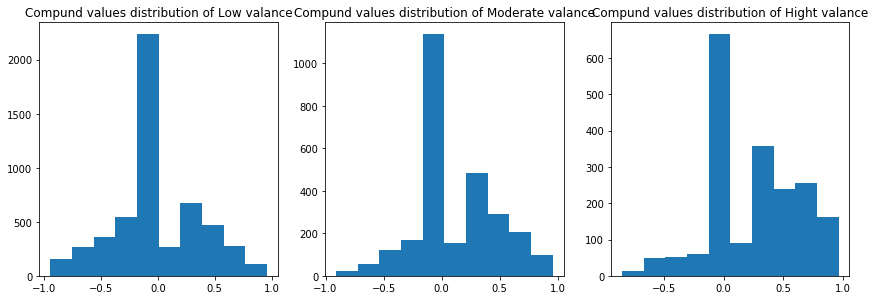

In [38]:
output_valance_int = np.argmax(output_filtered[:,0], axis=1)
compounds = textual_fearures[:,0]


low_valance = compounds[output_valance_int == 0]
moderate_valance = compounds[output_valance_int == 1]
high_valance = compounds[output_valance_int == 2]

fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)
axs[0].hist(low_valance)
axs[0].set_title("Compund values distribution of Low valance")

axs[1].hist(moderate_valance)
axs[1].set_title("Compund values distribution of Moderate valance")

axs[2].hist(high_valance)
axs[2].set_title("Compund values distribution of Hight valance")




** Combine acoustic and textual **

In [8]:

acoustic_features = input_filtered
print(input_filtered.shape)
print(textual_fearures.shape)

input_filtered = np.column_stack((acoustic_features, textual_fearures))

print("Length input_filtered after combination: ", len(input_filtered[0]))

#input_filtered= input_filtered[:,-1]
num_features = len(input_filtered[0])

(10009, 88)
(10009, 3)
Length input_filtered after combination:  91


**Split data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(input_filtered, output_filtered, test_size=0.2, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))



Size training, testing set:  8007 ,  2002


**Training on keras**

In [10]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf

with tf.device('/device:CPU:0'):
    model = Sequential([
        Dense(3, input_shape=(num_features,), kernel_initializer='normal'),
       Activation('relu'),
        Dense(32, kernel_initializer='normal'),
        Activation('relu'),
        Dense(16,kernel_initializer='normal'),
        Activation('relu'),
        Dense(8, kernel_initializer='normal'),
        Activation('relu'),
        Dense(3,kernel_initializer='normal'),
         Activation('softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    model.fit(X_train, y_train[:,0], validation_data=(X_test, y_test[:,0]), epochs = 100)
    #model.fit(X_train[0:2], y_train[0:2,0], validation_data=(X_test[0:2], y_test[0:2,0]), epochs = 1000)

        
    
    

    model1 = Sequential([
        Dense(64, input_shape=(num_features,), kernel_initializer='normal'),
        Activation('relu'),
        Dense(32, kernel_initializer='normal'),
        Activation('relu'),
        Dense(16,kernel_initializer='normal'),
        Activation('relu'),
        Dense(8, kernel_initializer='normal'),
        Activation('relu'),
        Dense(3),
        Activation('softmax'),

    ])
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    model1.fit(X_train, y_train[:,1], validation_data=(X_test, y_test[:,1]), epochs = 20)


#     model2 = Sequential([
#         Dense(64, input_shape=(20,), kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(32, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(16,kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(8, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(1),
#     ])
#     model2.compile(loss='mean_squared_error', optimizer='adam')
#     model2.fit(X_train, y_train[:,2], validation_data=(X_test, y_test[:,2]), epochs = 20)



Train on 8007 samples, validate on 2002 samples
Epoch 1/100
8007/8007 [==============================] - ETA: 3:12 - loss: 1.0986 - acc: 0.281 - ETA: 5s - loss: 1.0933 - acc: 0.5076  - ETA: 2s - loss: 1.0867 - acc: 0.522 - ETA: 1s - loss: 1.0736 - acc: 0.530 - ETA: 1s - loss: 1.0601 - acc: 0.525 - ETA: 0s - loss: 1.0416 - acc: 0.531 - ETA: 0s - loss: 1.0341 - acc: 0.533 - ETA: 0s - loss: 1.0263 - acc: 0.536 - 1s 154us/step - loss: 1.0220 - acc: 0.5380 - val_loss: 1.0279 - val_acc: 0.5060
Epoch 2/100
8007/8007 [==============================] - ETA: 0s - loss: 1.0021 - acc: 0.531 - ETA: 0s - loss: 0.9901 - acc: 0.540 - ETA: 0s - loss: 0.9878 - acc: 0.544 - ETA: 0s - loss: 0.9941 - acc: 0.538 - ETA: 0s - loss: 0.9968 - acc: 0.536 - ETA: 0s - loss: 0.9963 - acc: 0.538 - ETA: 0s - loss: 0.9915 - acc: 0.543 - ETA: 0s - loss: 0.9944 - acc: 0.540 - 0s 49us/step - loss: 0.9943 - acc: 0.5402 - val_loss: 1.0212 - val_acc: 0.5060
Epoch 3/100
8007/8007 [==============================] - ETA: 0s - 

8007/8007 [==============================] - ETA: 0s - loss: 0.7505 - acc: 0.750 - ETA: 0s - loss: 0.9390 - acc: 0.573 - ETA: 0s - loss: 0.9244 - acc: 0.574 - ETA: 0s - loss: 0.9326 - acc: 0.567 - ETA: 0s - loss: 0.9122 - acc: 0.579 - ETA: 0s - loss: 0.9084 - acc: 0.582 - ETA: 0s - loss: 0.9132 - acc: 0.577 - ETA: 0s - loss: 0.9161 - acc: 0.577 - 0s 49us/step - loss: 0.9168 - acc: 0.5769 - val_loss: 0.9394 - val_acc: 0.5539
Epoch 20/100
8007/8007 [==============================] - ETA: 0s - loss: 1.0423 - acc: 0.437 - ETA: 0s - loss: 0.9096 - acc: 0.575 - ETA: 0s - loss: 0.9105 - acc: 0.583 - ETA: 0s - loss: 0.9154 - acc: 0.580 - ETA: 0s - loss: 0.9152 - acc: 0.579 - ETA: 0s - loss: 0.9173 - acc: 0.578 - ETA: 0s - loss: 0.9144 - acc: 0.581 - ETA: 0s - loss: 0.9159 - acc: 0.579 - 0s 52us/step - loss: 0.9162 - acc: 0.5790 - val_loss: 0.9368 - val_acc: 0.5564
Epoch 21/100
8007/8007 [==============================] - ETA: 0s - loss: 0.9697 - acc: 0.531 - ETA: 0s - loss: 0.9313 - acc: 0.556

8007/8007 [==============================] - ETA: 0s - loss: 0.8891 - acc: 0.531 - ETA: 0s - loss: 0.8955 - acc: 0.582 - ETA: 0s - loss: 0.9102 - acc: 0.574 - ETA: 0s - loss: 0.9066 - acc: 0.574 - ETA: 0s - loss: 0.9041 - acc: 0.578 - ETA: 0s - loss: 0.9028 - acc: 0.578 - ETA: 0s - loss: 0.9005 - acc: 0.581 - ETA: 0s - loss: 0.8979 - acc: 0.582 - 0s 49us/step - loss: 0.8987 - acc: 0.5826 - val_loss: 0.9228 - val_acc: 0.5509
Epoch 38/100
8007/8007 [==============================] - ETA: 0s - loss: 0.9071 - acc: 0.625 - ETA: 0s - loss: 0.8785 - acc: 0.596 - ETA: 0s - loss: 0.8937 - acc: 0.584 - ETA: 0s - loss: 0.8954 - acc: 0.584 - ETA: 0s - loss: 0.8918 - acc: 0.584 - ETA: 0s - loss: 0.8917 - acc: 0.586 - ETA: 0s - loss: 0.8953 - acc: 0.582 - 0s 44us/step - loss: 0.8952 - acc: 0.5835 - val_loss: 0.9263 - val_acc: 0.5534
Epoch 39/100
8007/8007 [==============================] - ETA: 0s - loss: 0.8529 - acc: 0.625 - ETA: 0s - loss: 0.8962 - acc: 0.562 - ETA: 0s - loss: 0.8950 - acc: 0.578

Epoch 56/100
8007/8007 [==============================] - ETA: 0s - loss: 0.8287 - acc: 0.656 - ETA: 0s - loss: 0.8604 - acc: 0.590 - ETA: 0s - loss: 0.8763 - acc: 0.591 - ETA: 0s - loss: 0.8831 - acc: 0.585 - ETA: 0s - loss: 0.8856 - acc: 0.585 - ETA: 0s - loss: 0.8880 - acc: 0.581 - ETA: 0s - loss: 0.8918 - acc: 0.581 - ETA: 0s - loss: 0.8889 - acc: 0.582 - ETA: 0s - loss: 0.8847 - acc: 0.584 - 0s 60us/step - loss: 0.8817 - acc: 0.5860 - val_loss: 0.9145 - val_acc: 0.5634
Epoch 57/100
8007/8007 [==============================] - ETA: 0s - loss: 0.7755 - acc: 0.687 - ETA: 0s - loss: 0.8902 - acc: 0.581 - ETA: 0s - loss: 0.8758 - acc: 0.586 - ETA: 0s - loss: 0.8747 - acc: 0.591 - ETA: 0s - loss: 0.8792 - acc: 0.591 - ETA: 0s - loss: 0.8810 - acc: 0.590 - ETA: 0s - loss: 0.8799 - acc: 0.591 - ETA: 0s - loss: 0.8820 - acc: 0.589 - ETA: 0s - loss: 0.8846 - acc: 0.587 - ETA: 0s - loss: 0.8805 - acc: 0.587 - 1s 64us/step - loss: 0.8817 - acc: 0.5871 - val_loss: 0.9145 - val_acc: 0.5624
Epoc

8007/8007 [==============================] - ETA: 0s - loss: 0.8411 - acc: 0.625 - ETA: 0s - loss: 0.8594 - acc: 0.598 - ETA: 0s - loss: 0.8687 - acc: 0.596 - ETA: 0s - loss: 0.8727 - acc: 0.590 - ETA: 0s - loss: 0.8726 - acc: 0.590 - ETA: 0s - loss: 0.8706 - acc: 0.590 - ETA: 0s - loss: 0.8682 - acc: 0.592 - ETA: 0s - loss: 0.8716 - acc: 0.589 - ETA: 0s - loss: 0.8742 - acc: 0.586 - ETA: 0s - loss: 0.8778 - acc: 0.584 - ETA: 0s - loss: 0.8772 - acc: 0.586 - 1s 70us/step - loss: 0.8773 - acc: 0.5861 - val_loss: 0.9161 - val_acc: 0.5619
Epoch 74/100
8007/8007 [==============================] - ETA: 0s - loss: 0.9952 - acc: 0.500 - ETA: 0s - loss: 0.8884 - acc: 0.564 - ETA: 0s - loss: 0.8867 - acc: 0.575 - ETA: 0s - loss: 0.8835 - acc: 0.577 - ETA: 0s - loss: 0.8788 - acc: 0.582 - ETA: 0s - loss: 0.8792 - acc: 0.582 - ETA: 0s - loss: 0.8802 - acc: 0.584 - ETA: 0s - loss: 0.8750 - acc: 0.585 - ETA: 0s - loss: 0.8762 - acc: 0.586 - ETA: 0s - loss: 0.8772 - acc: 0.587 - 1s 63us/step - loss:

8007/8007 [==============================] - ETA: 0s - loss: 0.9795 - acc: 0.468 - ETA: 0s - loss: 0.8881 - acc: 0.579 - ETA: 0s - loss: 0.8698 - acc: 0.592 - ETA: 0s - loss: 0.8646 - acc: 0.595 - ETA: 0s - loss: 0.8688 - acc: 0.591 - ETA: 0s - loss: 0.8741 - acc: 0.593 - ETA: 0s - loss: 0.8743 - acc: 0.596 - ETA: 0s - loss: 0.8777 - acc: 0.592 - ETA: 0s - loss: 0.8761 - acc: 0.591 - 0s 58us/step - loss: 0.8764 - acc: 0.5905 - val_loss: 0.9082 - val_acc: 0.5634
Epoch 90/100
8007/8007 [==============================] - ETA: 0s - loss: 0.9729 - acc: 0.562 - ETA: 0s - loss: 0.8790 - acc: 0.593 - ETA: 0s - loss: 0.8906 - acc: 0.579 - ETA: 0s - loss: 0.8910 - acc: 0.578 - ETA: 0s - loss: 0.8785 - acc: 0.586 - ETA: 0s - loss: 0.8701 - acc: 0.588 - ETA: 0s - loss: 0.8747 - acc: 0.588 - ETA: 0s - loss: 0.8761 - acc: 0.587 - 0s 53us/step - loss: 0.8761 - acc: 0.5892 - val_loss: 0.9117 - val_acc: 0.5629
Epoch 91/100
8007/8007 [==============================] - ETA: 0s - loss: 0.9769 - acc: 0.437

8007/8007 [==============================] - ETA: 0s - loss: 0.6874 - acc: 0.625 - ETA: 0s - loss: 0.7498 - acc: 0.657 - ETA: 0s - loss: 0.7728 - acc: 0.631 - ETA: 0s - loss: 0.7662 - acc: 0.637 - ETA: 0s - loss: 0.7613 - acc: 0.642 - ETA: 0s - loss: 0.7661 - acc: 0.639 - ETA: 0s - loss: 0.7637 - acc: 0.640 - ETA: 0s - loss: 0.7649 - acc: 0.640 - ETA: 0s - loss: 0.7697 - acc: 0.640 - ETA: 0s - loss: 0.7693 - acc: 0.639 - 1s 63us/step - loss: 0.7685 - acc: 0.6392 - val_loss: 0.7931 - val_acc: 0.6164
Epoch 7/20
8007/8007 [==============================] - ETA: 0s - loss: 0.7059 - acc: 0.656 - ETA: 0s - loss: 0.7566 - acc: 0.644 - ETA: 0s - loss: 0.7568 - acc: 0.657 - ETA: 0s - loss: 0.7713 - acc: 0.641 - ETA: 0s - loss: 0.7633 - acc: 0.647 - ETA: 0s - loss: 0.7631 - acc: 0.643 - ETA: 0s - loss: 0.7623 - acc: 0.643 - ETA: 0s - loss: 0.7678 - acc: 0.642 - ETA: 0s - loss: 0.7666 - acc: 0.643 - 0s 57us/step - loss: 0.7663 - acc: 0.6433 - val_loss: 0.7915 - val_acc: 0.6294
Epoch 8/20
8007/800

**Result**

In [12]:
from sklearn.metrics import log_loss


pre = model.predict_classes(X_test)
y_int = np.argmax(y_test[:,0], axis=1)
print(confusion_matrix(y_int, pre), "\n")


pre = model1.predict_classes(X_test)
#pre = model1.predict(X_test)
#pre = np.argmax(pre, axis =1)
y_int = np.argmax(y_test[:,1], axis=1)
print(confusion_matrix(y_int, pre))
prob =  model1.predict(X_test)
for i in range(0,20):
    print(prob[i],", " ,y_int[i])
print("Log_loss:",log_loss(y_int, prob))

pre = model2.predict_classes(X_test)
y_int = np.argmax(y_test[:,2], axis=1)
print("\n",confusion_matrix(y_int, pre))


# [[1001    0   62]
#  [ 462    0   87]
#  [ 261    0  129]] 

# [[383 240   4]
#  [197 813  40]
#  [  8 200 117]]



[[944  42  27]
 [470  59  35]
 [249  60 116]] 

[[413 202   3]
 [264 755  30]
 [ 12 230  93]]
[0.40053058 0.5704209  0.02904855] ,  0
[0.0140562  0.4327929  0.55315095] ,  2
[0.29926488 0.6475718  0.05316335] ,  1
[0.26691413 0.6610558  0.07202996] ,  1
[8.4274352e-01 1.5647501e-01 7.8145257e-04] ,  0
[0.51666224 0.46577373 0.01756407] ,  1
[0.3015513  0.6419258  0.05652288] ,  0
[0.6074382  0.38008502 0.0124768 ] ,  0
[8.3340734e-01 1.6577919e-01 8.1345841e-04] ,  1
[0.22864468 0.679418   0.09193728] ,  1
[0.25440872 0.6673801  0.0782112 ] ,  2
[0.02013795 0.47608697 0.5037751 ] ,  1
[0.23987187 0.6749087  0.08521948] ,  1
[0.30883783 0.62986505 0.06129718] ,  1
[0.00306397 0.25540805 0.741528  ] ,  2
[0.5422972  0.44796008 0.00974272] ,  1
[0.29282123 0.6372891  0.0698896 ] ,  0
[0.31405944 0.6494018  0.03653873] ,  1
[0.620581   0.36807388 0.01134521] ,  1
[0.7837961  0.21421109 0.0019929 ] ,  0
Log_loss: 0.7955506107547543


NameError: name 'model2' is not defined

**Ordinal logistic regression**

In [ ]:
import mord
from sklearn import linear_model, metrics, preprocessing

clf2 = mord.LogisticAT(alpha=1)
#clf2 = mord.LogisticIT(alpha=1)
#clf2 = mord.LAD()
#clf2 = mord.OrdinalRidge()
#clf2 = mord.MulticlassLogistic()

y_train_AT = y_train 
y_train_AT = y_train_AT.astype(int)
y_test_AT = y_test.astype(int)

clf2.fit(X_train, y_train_AT[:,1] )

print(metrics.mean_absolute_error(model1.predict(X_test), y_test_AT[:,1]))
print('Mean Absolute Error of LogisticAT %s' % metrics.mean_absolute_error(clf2.predict(X_test), y_test_AT[:,1]))

print(clf2.predict(X_test)[0:3])
#print(clf2.predict_proba(X_test)[0:3])


**Coefficient of Determination**

In [ ]:
from sklearn.metrics import r2_score

#predict = model.predict(X_test)
predict1 = model1.predict(X_test)
#predict2 = model2.predict(X_test)

# a = r2_score(y_test[:,0], predict)
# print("The R2 for Valance: " ,a)

a1 = r2_score(y_test[:,1], predict1)
print("The R2 for Activation: " ,a1)

# a2 = r2_score(y_test[:,2], predict2)
# print("The R2 for Dominance: " ,a2)


**Distribution of err**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 10)
data = np.abs(predict1 - y_test[:,1])
print(len(data))
hist, bin_edges = np.histogram(data,bins) # make the histogram
print(hist)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# # Set the ticks to the middle of the bars
# ax.set_xticks([0.5+i for i,j in enumerate(hist)])

# # # Set the xticklabels to a string that tells us what the bin edges were
# # ax.set_xticklabels(['{} - {}'.format(bins[i],bins[i+1]) for i,j in enumerate(hist)])

plt.show()


#predict = model.predict(X_test)

#plt.hist(subs, bins =bins)

**Standard residual plot**

In [ ]:
import seaborn as sns
from matplotlib.pyplot import subplots_adjust
sns.set(style="whitegrid")

fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
predict = model.predict(X_test)
predict = np.array([p[0] for p in predict])
axs[0] = sns.residplot(y_test[:,0], predict, lowess=True, color="g", ax=axs[0])
axs[0].set_ylim([-0.4,0.4])
axs[0].set_title("Residual for Valance") 


predict1 = model1.predict(X_test)
predict1 = np.array([p[0] for p in predict1])
axs[1] = sns.residplot(y_test[:,1], predict1, lowess=True, color="r", ax=axs[1])
axs[1].set_ylim([-0.4,0.4])
axs[1].set_title("Residual for Activation")

predict2 = model2.predict(X_test)
predict2 = np.array([p[0] for p in predict2])
axs[2] = sns.residplot(y_test[:,2], predict2, lowess=True, color="b", ax=axs[2])
axs[2].set_ylim([-0.5,0.5])
axs[2].set_title("Residual for Dominance")


plt.show()
plt.close()


The residual plot show that the error followed random pattern. If the residual plot is not enough random, then the model would be likely to lose something. 

**Playing around with prediction**

In [ ]:

predict = model.predict(X_test)
#print(predict)

subs = np.abs(predict - y_test[:,0])


fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
axs[0].hist(y_train[:,0])
axs[0].set_title("True value in train data\n" + 
                 "avg:" + str(np.average(y_train[:,0])) + 
                 "\nstd:" + str(np.std(y_train[:,0])))
axs[1].hist(y_test[:,0])
axs[1].set_title("True value in test data\n" + 
                 "avg:" + str(np.average(y_test[:,0])) + 
                 "\nstd:" + str(np.std(y_test[:,0])))
axs[1].set_ylim([0,400])
                        
axs[2].hist(predict) 
axs[2].set_title("Prediction\n" +
                "avg:" + str(np.average(predict)) + 
                 "\nstd:" + str(np.std(predict)))
                
# axs[2].hist(subs, bins='auto')
# axs[2].set_title("error on predictions")

plt.show()
plt.close()


In [ ]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

predict = model1.predict(X_test)
bins = np.linspace(0, 1, 6)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)

# y = y_test[:,1]
# subs = np.abs(y-predict)
# print("ave, std, per90:", np.average(subs), ", ", np.std(subs), ",", np.percentile(subs, 60))
    
for r in bin_ranges:
    # Get valance
    y = y_test[:,1]
    condition1 = [r[0] <= e <= r[1]for e in y]
    
    predict = predict.flatten()
    condition2 = [r[0] <= e <= r[1]for e in predict]
    
    y = y[condition1 or condition2]
    pre = predict[condition1 or condition2]
    #pre= pre.flatten()
    #print(pre)
    subs = np.abs(y-pre)
   # print(subs)
    try:
        #print(subs)
        print("\nIn range " , r, 
              "\nNum samples: ", len(subs),
              "\nAverage err: ", np.average(subs), 
              "\nStd err: ", np.std(subs),
              "\nMedian err: ", np.median(subs), 
             "\nPercentile: ", np.percentile(subs, 90),
              "\nConfident Interval: ", mean_confidence_interval(subs)
             )
    except:
        print("null array")

    

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

predict = clf2.predict(X_test)
bins = np.linspace(0, 6, 7)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)


for r in bin_ranges:
    # Get valance
    y = y_test[:,1]
    condition1 = [r[0] <= e <= r[1]for e in y]
    
    predict = predict.flatten()
    condition2 = [r[0] <= e <= r[1]for e in predict]
    
    y = y[condition1 or condition2]
    pre = predict[condition1 or condition2]
    #pre= pre.flatten()
    print(pre)
    subs = np.abs(y-pre)
   # print(subs)
    try:
        print(subs)
        print("\nIn range " , r, 
              "\nNum samples: ", len(subs),
              "\nAverage err: ", np.average(subs), 
              "\nStd err: ", np.std(subs),
              "\nMedian err: ", np.median(subs), 
             "\nPercentile: ", np.percentile(subs, 95),
              "\nConfident Interval: ", mean_confidence_interval(subs)
             )
    except:
        print("null array")

    

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt


predict = model.predict(X_test)
predict = np.array([p[0] for p in predict])

predict1 = model1.predict(X_test)
predict1 = np.array([p[0] for p in predict1])

predict2 = model2.predict(X_test)
predict2 = np.array([p[0] for p in predict2])

fig, ax = plt.subplots()
ax.scatter(y_test[:,1], predict1, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# ax[1].scatter(y_test[:,1], predict, edgecolors=(0, 0, 0))
# ax[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
# ax[1].set_xlabel('Actual')
# ax[1].set_ylabel('Predicted')

# ax[2].scatter(y_test[:,2], predict, edgecolors=(0, 0, 0))
# ax[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
# ax[2].set_xlabel('Actual')
# ax[2].set_ylabel('Predicted')

plt.show()

**Playing around **

In [ ]:
from functools import reduce
predict = model2.predict(X_test)

def reducer(acc, val):
    if (val > 0.5):
        acc = acc + 1
    return acc

num = reduce(lambda acc,val: acc+1 if val >1 else acc, predict.flatten(), 0) 
print(num)

**Confidence in interval for Arouse**

In [ ]:
predict = clf2.predict(X_test)
print(predict)
#predict = clf2.predict(X_test)
#print(predict)
#predict = np.array([p[0] for p in predict])
y = y_test[:, 1]
y1=y
#y1 = np.argmax(y,1)
cm = confusion_matrix(y1, predict)
print("Confusion matrix: \n", cm)


bins = np.linspace(0, 5, 6)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)

for r in bin_ranges:
     condition = [r[0] <= e <= r[1] for e in y]
     y1 = y[condition]
     pre = predict.flatten()
     pre = pre[condition]
     num_true = 0
     for i in range (0, len(y1)):
        if (np.abs(y1[i] - pre[i]) ==0 ):
            num_true += 1
     print("Num samples:", len(pre))
     print("Accurcy in range: ", r, ": ", num_true / (len(pre) +1 ) )
            

fig, ax = plt.subplots(1,3)
y_int = y.astype(int)

ax[0].hist(y)
ax[0].set_ylim([0,650])
ax[1].hist(y_int)
ax[1].set_ylim([0,650])
ax[2].hist(predict)
ax[2].set_ylim([0,650])
        
print(set(predict))
print(len(predict))



### 